In [1]:
import os
import sys
import yaml
import json
import warnings
import numpy as np
import pandas as pd
import gurobipy as gp
from analysis import analysis
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.contrib import itertools

pd.set_option('display.max_rows', None)
sys.path.append("/Users/ashutoshshukla/Desktop/TwoStageModel/")

from utils import prepare_input
from main_model import two_stage_model

pd.options.display.max_seq_items = 200
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings("ignore")

In [2]:
model_repo = {}

for i in [16]:
    for j in ["sm_", "rm_"]:
        if i == 192:
            if "r" in j:
                break
        print(i, j)
        model = analysis(i,j)
        print("Number of flooded substations\t", model.n_flooded_substations)
        print("Number of hardened substation as a function of budget")
        print(model.substation_hardened_with_budget())
        print("Non nested substations")
        print(model.non_nested_substation_count())
        model_repo[j+str(i)] = model
        print("\n")

16 sm_
Number of flooded substations	 182
Number of hardened substation as a function of budget
0 (0, 9)
10 (13, 9)
20 (27, 9)
30 (36, 9)
40 (44, 9)
50 (52, 9)
60 (58, 9)
70 (65, 9)
80 (72, 9)
None
Non nested substations
Substation not having nested hardening:	 37
Substation not having nested hardening:	 49
Substation not having nested hardening:	 279
Substation not having nested hardening:	 335
None


16 rm_
Number of flooded substations	 182
Number of hardened substation as a function of budget
0 (0, 9)
10 (17, 9)
20 (29, 9)
30 (35, 9)
40 (47, 9)
50 (52, 9)
60 (58, 9)
70 (65, 9)
80 (70, 9)
None
Non nested substations
Substation not having nested hardening:	 6
Substation not having nested hardening:	 37
Substation not having nested hardening:	 47
Substation not having nested hardening:	 153
Substation not having nested hardening:	 177
Substation not having nested hardening:	 315
None




In [3]:
load = []
gen_min = []
gen_max = []

for i in model_repo["sm_16"].main_df.index:
    load.append(model_repo["sm_16"].base_model.input1[model_repo["sm_16"].base_model.input1["SubNum"] == i].iloc[0,8])
    gen_min.append(model_repo["sm_16"].base_model.input1[model_repo["sm_16"].base_model.input1["SubNum"] == i].iloc[0,6])
    gen_max.append(model_repo["sm_16"].base_model.input1[model_repo["sm_16"].base_model.input1["SubNum"] == i].iloc[0,7])
    
model_repo["sm_16"].hardening_df["load"] = load
model_repo["sm_16"].hardening_df["gen_min"] = gen_min
model_repo["sm_16"].hardening_df["gen_max"] = gen_max

## Load distribution

In [4]:
def load_profile_plotter(budget, model_id = "sm_", n_scenario=8):
    sol_path = "/Users/ashutoshshukla/Desktop/TwoStageModel/output/" + model_id + str(n_scenario) + "/" + str(budget) + "M_solution.sol"
    big_model = analysis(n_scenario, model_id)
    big_model.base_model.model.read(sol_path)
    big_model.base_model.model.update()
    
    df_load = pd.DataFrame(np.zeros((big_model.base_model.n_buses, big_model.base_model.n_scenarios)))
    for i in range(big_model.base_model.n_buses):
        for j in range(big_model.base_model.n_scenarios):
            satisfied = big_model.base_model.model.getVarByName('s[' +  str(i) + "," + str(j) + ']').Start
            df_load.iloc[i,j] = big_model.model_params["input1"].iloc[i,8] - satisfied

    return df_load

In [5]:
load_profiles_dict = {}
for i in range(0,90,10):
    load_profiles_dict[i] = load_profile_plotter(i, model_id = "sm_", n_scenario=16).sum()

## Robust Distribution

In this case, we fix the robust decisions and solve the stochastic model

In [6]:
n_scenario = 16
budget_vector = [0,10,20,30,40,50,60,70,80]
num_scenario = '/' + str(n_scenario) + '_Scenario/'

In [7]:
with open(r'../config.yaml') as file:
    model_params = yaml.load(file, Loader=yaml.FullLoader)

model_params["path_to_input"] = '/Users/ashutoshshukla/Desktop/Data/fixed_reduced_grid' + num_scenario
model_params["input1"], model_params["input2"] = prepare_input(model_params["path_to_input"])

print("MIP-Gap: ", model_params["mip_gap"])
print("Time Limit: ", model_params["time_limit"])
print("Robust Model: ", model_params["robust_flag"])
print("Flexible Generation: ", model_params["flexible_generation"])
print("Objective Type:\t", model_params["set_objective"], "\n")
print("Solver Method:\t", model_params["solver_method"], "\n")

flood_df = model_params["input1"].iloc[:,9:].copy()
flood_df_columns = flood_df.columns
input1_copy = model_params["input1"].drop(flood_df_columns, axis=1).copy()

MIP-Gap:  0.005
Time Limit:  21600
Robust Model:  False
Flexible Generation:  True
Objective Type:	 min 

Solver Method:	 2 



In the following block, we first use the first-stage RO decisions. Then we fix them in stochastic model to compute the load-shed.

In [8]:
robust_dict = {}
model_id = "rm_"
n_scenario = 16

for budget in budget_vector:
    robust_dict[budget] = []

for budget, scenario in itertools.product(budget_vector, flood_df_columns):
    model_params["input1"] = input1_copy.copy()
    model_params["input1"][scenario] = flood_df[scenario]
    base_model = two_stage_model(model_params)
    
    sol_path = "/Users/ashutoshshukla/Desktop/TwoStageModel/output/" + model_id + str(n_scenario) + "/" + str(budget) + "M_solution.sol"
    big_model = analysis(n_scenario, model_id)
    big_model.base_model.model.read(sol_path)
    big_model.base_model.model.update()
    
    for i in big_model.base_model.unique_substations:
        decision_x = int(big_model.base_model.model.getVarByName('x[' +  str(i) + ']').Start)
        base_model.model.addConstr(base_model.x[i] == decision_x)
    
    base_model.budget_ref.rhs = budget*1e6
    base_model.model.setParam("LogToConsole", 0)
    base_model.model.setParam("MIPGap", model_params["mip_gap"])
    base_model.model.setParam("TimeLimit", model_params["time_limit"])
    base_model.model.setParam("Method", model_params["solver_method"])
    base_model.model.optimize()
    
    robust_dict[budget].append(base_model.model.objVal)

  0%|          | 0/144 [00:00<?, ?it/s]

In [9]:
# for i in robust_dict:
#     robust_dict[i] = list(robust_dict[i])
    
# json_object = json.dumps(robust_dict, indent=4)

# with open("robust_cdf_16_dict.json", "w") as outfile:
#     outfile.write(json_object)

In [10]:
def sub_plots(budget_value, robust_dict, load_profiles_dict, ax):
    
    count, bins_count = np.histogram(pd.Series(robust_dict[budget_value])/10, bins=16)
    pdf = count/sum(count)
    cdf = np.cumsum(pdf)
    ax[int(np.floor(budget_value/40)), int(budget_value/10)%4].plot(bins_count[1:], cdf, label="Robust solution", color="#0072b2")
    
    if int(np.floor(budget_value/40)) == 1:
        ax[int(np.floor(budget_value/40)), int(budget_value/10)%4].set_xlabel("Load-shed in GW",fontsize=11)
    
    # if  int(budget_value/10)%4 == 0:
    #     ax[int(np.floor(budget_value/40)), int(budget_value/10)%4].set_ylabel("CDF value",fontsize=11)
    
    
    count, bins_count = np.histogram(load_profiles_dict[budget_value]/10, bins=16)
    pdf = count/sum(count)
    cdf = np.cumsum(pdf)
    ax[int(np.floor(budget_value/40)), int(budget_value/10)%4].plot(bins_count[1:], cdf, label="Stochastic solution", color="#d55e00", linestyle="dashdot") 
    
    if int(np.floor(budget_value/40)) == 1:
        ax[int(np.floor(budget_value/40)), int(budget_value/10)%4].set_xlabel("Load-shed in GW",fontsize=11)
    
    # if  int(budget_value/10)%4 == 0:
    #     ax[int(np.floor(budget_value/40)), int(budget_value/10)%4].set_ylabel("CDF value",fontsize=11)
        
    ax[int(np.floor(budget_value/40)), int(budget_value/10)%4].set_title("Budget: $" + str(budget_value) + "M")

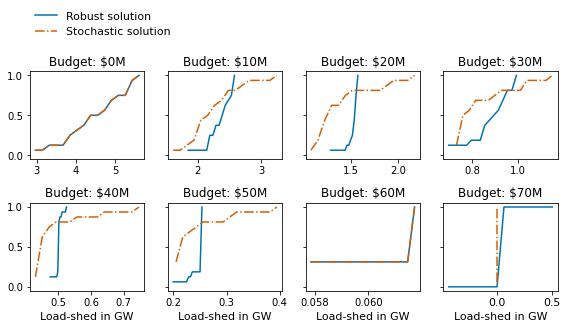

In [11]:
fig, ax = plt.subplots(2, 4, figsize=(8,4), sharey=True)


start_bud=0
end_bud=80
interval_bud = 10

for budget_value in range(start_bud,end_bud,interval_bud):
    sub_plots(budget_value, robust_dict, load_profiles_dict, ax)
    
    
#plt.legend(loc=0, prop={'size': 16})

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', frameon=False, bbox_to_anchor=(0.05, 1.15), fontsize=11)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
#plt.savefig("/Users/ashutoshshukla/Desktop/TwoStageModel/Figures/mixed_distribution.eps", format="eps", bbox_inches="tight")
plt.show()
plt.close()

In [12]:
stochastic_dict = load_profiles_dict

In [13]:
def return_plot_info(data, bin_count=4, y_value=0, width_t = 0.7, depth_t = 0.1):
    
    frequency, bin_edges = np.histogram(data, bin_count)
    bin_edges = (bin_edges/10).round(3)

    center = (bin_edges[:-1] + bin_edges[1:])/2
    
    _x = center
    _y = np.array([y_value])
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    top = frequency
    bottom = np.zeros_like(top)
    width = width_t*(bin_edges[1] - bin_edges[0])    
    depth=depth_t

    return x,y,bottom, width, depth, top

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


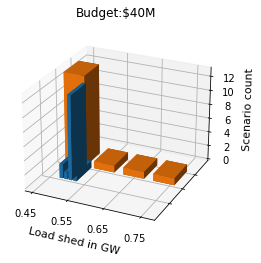

In [102]:
budget_value = 40

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot(projection='3d')

x_r, y_r, bottom_r, width_r, depth_r, top_r = return_plot_info(pd.Series(robust_dict[budget_value]).round(3), 4, 0.2, 0.7, 0.1)
x_s, y_s, bottom_s, width_s, depth_s, top_s = return_plot_info(pd.Series(stochastic_dict[budget_value]).round(3), 4, 0.3, 0.7, 0.1)

ax1.bar3d(x_r, y_r, bottom_r, width_r, depth_r, top_r, shade=True)
ax1.bar3d(x_s, y_s, bottom_s, width_s, depth_s, top_s, shade=True)

ax1.set_title('Budget:' + "$" + str(budget_value) + "M", fontsize=12)
ax1.set_xlabel("Load shed in GW", fontsize=11)
ax1.set_zlabel("Scenario count", fontsize=11)
ax1.set_ylim(0.1,0.5)
ax1.set_yticks([0.2,0.3,0.4], ["", "", ""])


if budget_value == 60:
    ax1.set_xlim(0.056, 0.063)
    ax1.set_xticks(np.linspace(0.056, 0.063,3))

if budget_value == 70:
    low = -0.1
    high = 0.18
    ax1.set_xlim(low, high)
    ax1.set_xticks(np.linspace(low, high,3))
    ax1.set_zticks([0,4,8,12,16], [0,4,8,12,16])
    
if budget_value == 40:
    ax1.set_xticks([0.45, 0.55, 0.65, 0.75], [0.45, 0.55, 0.65, 0.75])
    
    
ax1.view_init(25, -65)

plt.savefig("/Users/ashutoshshukla/Desktop/" + str(budget_value) + ".eps", format="eps")

# Dr. K lamda analaysis

In [115]:
lister = []
budget_vector = np.arange(0,90,10)

for i in budget_vector:
    lister.append(float((pd.Series((stochastic_dict[i]).mean()/10).round(3))))
    
smallest = 15000
largest = 2400000

df = pd.DataFrame(lister)
df = df.set_index(budget_vector)

In [117]:
step_collector = []

for lamda in np.arange(0,75000,100):
    temp_lister = budget_vector*1e6 + df[0]*lamda*1000
    step_collector.append((round(lamda, 0), temp_lister.idxmin()))
    
step_collector = pd.DataFrame(step_collector)

main_info = []

temp_df = step_collector.values

for i in range(1,len(temp_df)):
    if temp_df[i,1] > temp_df[i-1,1]:
        main_info.append((temp_df[i,0], temp_df[i,1]))
        
main_info.insert(0, (0,0))
main_info = pd.DataFrame(main_info)

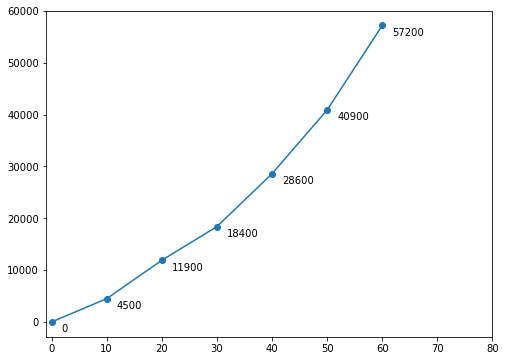

In [110]:
plt.figure(figsize=(8,6))
plt.plot(main_info[1], main_info[0], "-o")
plt.xlim(-1,80)
labels = main_info[0].astype(str).values.tolist()

for i, txt in enumerate(labels):
    text = plt.annotate(txt, (main_info.iloc[i,1], main_info.iloc[i,0]), fontsize=10, textcoords="offset points", xytext=(10,-10))

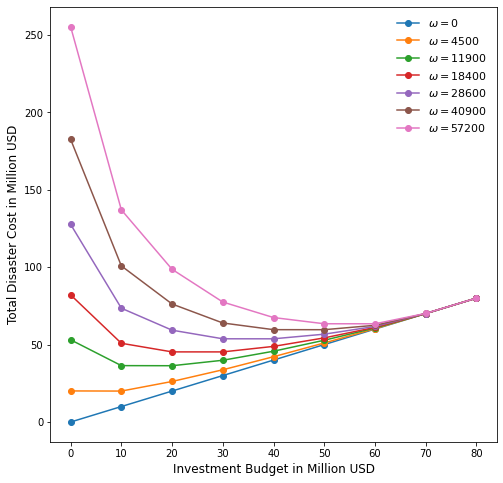

In [112]:
plt.figure(figsize=(8,8))

for i in range(len(main_info)):
    temp_lister = (budget_vector*1e6 + df[0]*main_info.iloc[i,0]*1000)/1e6
    plt.plot(budget_vector, temp_lister, '-o', label=r'$\omega = $' +  str(main_info.iloc[i,0]))
    plt.legend()
plt.xlabel("Investment Budget in Million USD", fontsize=12)
plt.ylabel("Total Disaster Cost in Million USD", fontsize=12)
plt.legend(frameon=False, fontsize=11)    
#plt.savefig("/Users/ashutoshshukla/Desktop/voll_quick_rule.eps", format="eps")


# New plot

In [260]:
# plt.figure(figsize=(4,4))
# voll = [value]
# restoration_time = 6


# lister = []
# budget_vector = np.arange(0,90,10)

# for i in budget_vector:
#     lister.append(float((pd.Series((stochastic_dict[i]).mean()/10).round(3))))

# df = pd.DataFrame(lister).set_index(budget_vector)

# step_collector = []
# for voll_value in voll:
#     lamda = 10*voll_value*restoration_time
#     temp_lister = budget_vector*1e6 + df[0]*lamda*1000
#     step_collector.append((round(lamda, 0)/1e3, temp_lister.idxmin(), temp_lister.min()/1e6))

# omega_vector = pd.DataFrame(voll)*10*restoration_time

# for i in range(len(omega_vector)):
#     temp_lister = (budget_vector*1e6 + df[0]*omega_vector.iloc[i,0]*1000)/1e6
#     plt.plot(budget_vector, temp_lister, '-o', label=r'$\omega = $' +  str(omega_vector.iloc[i,0]))
#     plt.legend()

# # plt.xlabel("Investment Budget in Million USD", fontsize=12)
# # plt.ylabel("Total Disaster Cost in Million USD", fontsize=12)

# plt.legend(frameon=False, fontsize=11, loc = "upper right")    
# plt.vlines(step_collector[0][1], 0, step_collector[0][2], color="red", linestyles="dashed")

# if voll[0] == 1000:
#     plt.ylim(0,300)

# if voll[0] == 250:
#     plt.ylim(0,100)

# if voll[0] == 500:
#     plt.ylim(0,160)


# plt.xticks(np.arange(0,90,10))
# plt.tight_layout()
# plt.savefig("/Users/ashutoshshukla/Desktop/voll_lowest_" + str(voll[0]) + ".eps", format="eps")

In [403]:
def voll_analysis_plotter(value, ax, stochastic_dict):
    voll = [value]
    restoration_time = 6

    lister = []
    budget_vector = np.arange(0,90,10)

    for i in budget_vector:
        lister.append(float((pd.Series((stochastic_dict[i]).mean()/10).round(3))))

    df = pd.DataFrame(lister).set_index(budget_vector)

    step_collector = []
    for voll_value in voll:
        lamda = 10*voll_value*restoration_time
        temp_lister = budget_vector*1e6 + df[0]*lamda*1000
        step_collector.append((round(lamda, 0)/1e3, temp_lister.idxmin(), temp_lister.min()/1e6))

    omega_vector = pd.DataFrame(voll)*10*restoration_time

    for i in range(len(omega_vector)):
        temp_lister = (budget_vector*1e6 + df[0]*omega_vector.iloc[i,0]*1000)/1e6
        ax.plot(budget_vector, temp_lister, '-o')
        ax.text(.63, .95, r'$\omega = $' +  str(omega_vector.iloc[i,0]), ha='left', va='top', transform=ax.transAxes, fontsize=10)

    ax.vlines(step_collector[0][1], 0, step_collector[0][2], color="red", linestyles="dashed")

    if voll[0] == 250:
        ax.set_ylim(0,100)
        
    if voll[0] == 500:
        ax.set_ylim(0,160)
        
    if voll[0] == 1000:
        ax.set_ylim(0,300)
        
    if voll[0] == 3000:
        ax.set_ylim(0,900)
        
    ax.set_xticks(np.arange(0,90,10))

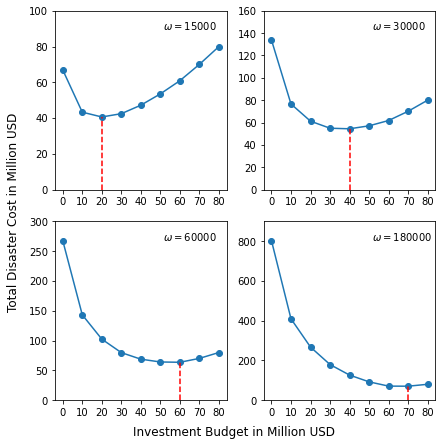

In [405]:
fig, ax_1 = plt.subplots(2, 2, figsize=(6,6))


voll_analysis_plotter(250, ax_1[0,0], stochastic_dict)
voll_analysis_plotter(500, ax_1[0,1], stochastic_dict)
voll_analysis_plotter(1000, ax_1[1,0], stochastic_dict)
voll_analysis_plotter(3000, ax_1[1,1], stochastic_dict)

fig.text(0.5, -0.01, 'Investment Budget in Million USD', ha='center', va='center', fontsize = 12)
fig.text(-0.01, 0.5, 'Total Disaster Cost in Million USD', ha='center', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.savefig("/Users/ashutoshshukla/Desktop/voll_quick_rule.eps", format="eps", bbox_inches="tight")